In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.1).csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [6]:
print(len(train_dataset), len(test_dataset))

56 112


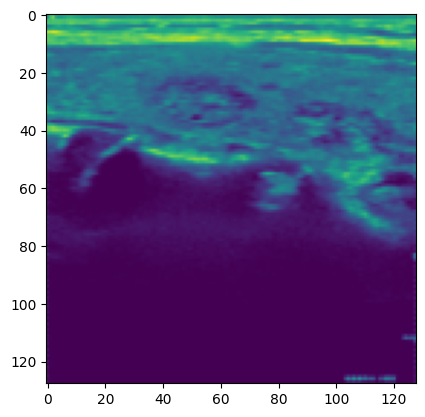

In [7]:
plt.imshow(image[10][0])

In [8]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [10]:
epochs = 200
lr = 0.01
project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.1)"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [11]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 200, batch size : 128


In [12]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [13]:
# loss_fn = DiceLoss()
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


train loss : 3.443045139312744, train IOU : 0.157612606883049, train DICE : 0.3058069944381714


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 2.380099296569824, val IOU : 0.0535714328289032, val DICE : 2.562999725341797e-06
epoch : 1


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 2.4289181232452393, train IOU : 0.013179791159927845, train DICE : 0.031816959381103516


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 11.498051643371582, val IOU : 0.07444927096366882, val DICE : 0.13858795166015625
epoch : 2


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.427446961402893, train IOU : 0.10440811514854431, train DICE : 0.17745590209960938


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.6972683668136597, val IOU : 0.098214291036129, val DICE : 0.002247154712677002
epoch : 3


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.2271887063980103, train IOU : 0.12235197424888611, train DICE : 0.16082561016082764


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.6977207660675049, val IOU : 0.098214291036129, val DICE : 0.0005867481231689453
epoch : 4


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.0645501613616943, train IOU : 0.15425607562065125, train DICE : 0.20178645849227905


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.5034327507019043, val IOU : 0.098214291036129, val DICE : 0.006915926933288574
epoch : 5


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.0193934440612793, train IOU : 0.10296626389026642, train DICE : 0.20238268375396729


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.4404934644699097, val IOU : 3.186838570812256e-09, val DICE : 0.015773415565490723
epoch : 6


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.002889633178711, train IOU : 0.07778230309486389, train DICE : 0.2091618776321411


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.2919230461120605, val IOU : 0.0010430316906422377, val DICE : 0.09053391218185425
epoch : 7


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


train loss : 0.9778148531913757, train IOU : 0.11754067242145538, train DICE : 0.2388940453529358


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.2306896448135376, val IOU : 0.09326161444187164, val DICE : 0.18619900941848755
epoch : 8


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.9583532214164734, train IOU : 0.1650886982679367, train DICE : 0.26877546310424805


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.3864699602127075, val IOU : 0.1222420483827591, val DICE : 0.20705044269561768
epoch : 9


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.9536574482917786, train IOU : 0.18577082455158234, train DICE : 0.2868839502334595


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.2886276245117188, val IOU : 0.10834803432226181, val DICE : 0.19822192192077637
epoch : 10


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.9334662556648254, train IOU : 0.19950057566165924, train DICE : 0.3014417290687561


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.2420803308486938, val IOU : 0.017026273533701897, val DICE : 0.13786733150482178
epoch : 11


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.9173458814620972, train IOU : 0.20061331987380981, train DICE : 0.3099750280380249


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.411048412322998, val IOU : 0.0024686232209205627, val DICE : 0.04211568832397461
epoch : 12


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.9620577096939087, train IOU : 0.13065046072006226, train DICE : 0.27341997623443604


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.3439288139343262, val IOU : 0.056056469678878784, val DICE : 0.1491779088973999
epoch : 13


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.9047799706459045, train IOU : 0.217983216047287, train DICE : 0.3330395817756653


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.643664002418518, val IOU : 0.08467363566160202, val DICE : 0.16176700592041016
epoch : 14


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.9093278050422668, train IOU : 0.217481791973114, train DICE : 0.338517427444458


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.6243259906768799, val IOU : 0.058588072657585144, val DICE : 0.12894397974014282
epoch : 15


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.8857673406600952, train IOU : 0.23135726153850555, train DICE : 0.3527960777282715


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.6624151468276978, val IOU : 0.05852104723453522, val DICE : 0.13062578439712524
epoch : 16


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.8799722194671631, train IOU : 0.23680317401885986, train DICE : 0.3592556118965149


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.5315351486206055, val IOU : 0.10163106769323349, val DICE : 0.18385916948318481
epoch : 17


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.8657037615776062, train IOU : 0.2545333206653595, train DICE : 0.3803119659423828


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 2.3962419033050537, val IOU : 0.1145567074418068, val DICE : 0.2026076316833496
epoch : 18


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.8474156856536865, train IOU : 0.26594457030296326, train DICE : 0.39489448070526123


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.9976192712783813, val IOU : 0.12879538536071777, val DICE : 0.23036926984786987
epoch : 19


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.8303788304328918, train IOU : 0.2709740102291107, train DICE : 0.404821515083313


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.9048707485198975, val IOU : 0.1371019333600998, val DICE : 0.24419498443603516
epoch : 20


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.8116186857223511, train IOU : 0.29094982147216797, train DICE : 0.4254944920539856


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.745149850845337, val IOU : 0.1601133644580841, val DICE : 0.27769309282302856
epoch : 21


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7979863286018372, train IOU : 0.31296584010124207, train DICE : 0.4342423677444458


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.8028178215026855, val IOU : 0.17243455350399017, val DICE : 0.28667473793029785
epoch : 22


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.7926328182220459, train IOU : 0.30670589208602905, train DICE : 0.45273280143737793


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.4151426553726196, val IOU : 0.2115349918603897, val DICE : 0.3418787717819214
epoch : 23


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.8396342992782593, train IOU : 0.2608852684497833, train DICE : 0.41637563705444336


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.5984996557235718, val IOU : 0.20815612375736237, val DICE : 0.32899999618530273
epoch : 24


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.7843888998031616, train IOU : 0.305292546749115, train DICE : 0.47110360860824585


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.4224439859390259, val IOU : 0.23219288885593414, val DICE : 0.3605530261993408
epoch : 25


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7915861010551453, train IOU : 0.30773767828941345, train DICE : 0.4569147825241089


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.3136390447616577, val IOU : 0.24076718091964722, val DICE : 0.3718339800834656
epoch : 26


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.760816216468811, train IOU : 0.33327996730804443, train DICE : 0.4725611209869385


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.4960052967071533, val IOU : 0.22406797111034393, val DICE : 0.3480411171913147
epoch : 27


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7567269802093506, train IOU : 0.36127474904060364, train DICE : 0.4850364923477173


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.7132487297058105, val IOU : 0.20887413620948792, val DICE : 0.32987523078918457
epoch : 28


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


train loss : 0.7354829907417297, train IOU : 0.373801052570343, train DICE : 0.506551206111908


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.7790212631225586, val IOU : 0.2019158899784088, val DICE : 0.32354992628097534
epoch : 29


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.7273288369178772, train IOU : 0.3551129698753357, train DICE : 0.5136800408363342


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7360401153564453, val IOU : 0.20455202460289001, val DICE : 0.32723569869995117
epoch : 30


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.7064472436904907, train IOU : 0.3761500120162964, train DICE : 0.5295507311820984


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.7429734468460083, val IOU : 0.20552246272563934, val DICE : 0.326820969581604
epoch : 31


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7081752419471741, train IOU : 0.3839384913444519, train DICE : 0.5389626622200012


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5799028873443604, val IOU : 0.2175615429878235, val DICE : 0.3468233346939087
epoch : 32


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6886813640594482, train IOU : 0.39517942070961, train DICE : 0.5412632822990417


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.5587643384933472, val IOU : 0.22963175177574158, val DICE : 0.3608856201171875
epoch : 33


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6704212427139282, train IOU : 0.4129021465778351, train DICE : 0.5688324570655823


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5237019062042236, val IOU : 0.24296455085277557, val DICE : 0.3747764825820923
epoch : 34


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6727554202079773, train IOU : 0.4364742040634155, train DICE : 0.5796272158622742


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.3497977256774902, val IOU : 0.2575596570968628, val DICE : 0.3905874490737915
epoch : 35


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6713855266571045, train IOU : 0.4459174871444702, train DICE : 0.5765185952186584


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.629818320274353, val IOU : 0.23125240206718445, val DICE : 0.3651033639907837
epoch : 36


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7224862575531006, train IOU : 0.3628539443016052, train DICE : 0.5372681617736816


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.6589486598968506, val IOU : 0.22488614916801453, val DICE : 0.3564743399620056
epoch : 37


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6577284336090088, train IOU : 0.4092159569263458, train DICE : 0.5752374529838562


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.6993085145950317, val IOU : 0.22416682541370392, val DICE : 0.3500376343727112
epoch : 38


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.6942766904830933, train IOU : 0.43133315443992615, train DICE : 0.5721009373664856


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.5378175973892212, val IOU : 0.24416662752628326, val DICE : 0.37539350986480713
epoch : 39


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6350225806236267, train IOU : 0.44624561071395874, train DICE : 0.5982642769813538


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.3739869594573975, val IOU : 0.26495203375816345, val DICE : 0.4006936550140381
epoch : 40


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6387017369270325, train IOU : 0.44540324807167053, train DICE : 0.5874731540679932


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.288110375404358, val IOU : 0.27039408683776855, val DICE : 0.41186708211898804
epoch : 41


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6302297115325928, train IOU : 0.4372498095035553, train DICE : 0.6021677255630493


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.1729204654693604, val IOU : 0.2766701877117157, val DICE : 0.41901928186416626
epoch : 42


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6564245223999023, train IOU : 0.4160093367099762, train DICE : 0.5776153206825256


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.3472073078155518, val IOU : 0.19895337522029877, val DICE : 0.32542741298675537
epoch : 43


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6729928851127625, train IOU : 0.40931472182273865, train DICE : 0.5817148089408875


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.1562809944152832, val IOU : 0.20791472494602203, val DICE : 0.36020541191101074
epoch : 44


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6630964279174805, train IOU : 0.39949730038642883, train DICE : 0.5771458148956299


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.0921194553375244, val IOU : 0.27713143825531006, val DICE : 0.43225252628326416
epoch : 45


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6471136212348938, train IOU : 0.41553744673728943, train DICE : 0.5935385227203369


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.3521126508712769, val IOU : 0.21026138961315155, val DICE : 0.3523213863372803
epoch : 46


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6347115635871887, train IOU : 0.44574302434921265, train DICE : 0.6098395586013794


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.4192439317703247, val IOU : 0.1484135240316391, val DICE : 0.2650942802429199
epoch : 47


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5866708755493164, train IOU : 0.48939698934555054, train DICE : 0.6471805572509766


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.4326329231262207, val IOU : 0.05674172565340996, val DICE : 0.14240610599517822
epoch : 48


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5988069772720337, train IOU : 0.4789934456348419, train DICE : 0.6380524635314941


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.3172805309295654, val IOU : 0.1262766420841217, val DICE : 0.2489873170852661
epoch : 49


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.5805448889732361, train IOU : 0.48846083879470825, train DICE : 0.6456364393234253


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.2574610710144043, val IOU : 0.18437212705612183, val DICE : 0.324677050113678
epoch : 50


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5497933626174927, train IOU : 0.5215123295783997, train DICE : 0.6677382588386536


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.189842939376831, val IOU : 0.23005405068397522, val DICE : 0.37695926427841187
epoch : 51


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5471618175506592, train IOU : 0.5103291273117065, train DICE : 0.677693247795105


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.1405439376831055, val IOU : 0.2486685812473297, val DICE : 0.40615057945251465
epoch : 52


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5209926962852478, train IOU : 0.5275620818138123, train DICE : 0.6968844532966614


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.1815887689590454, val IOU : 0.2140100747346878, val DICE : 0.3609471321105957
epoch : 53


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5032050609588623, train IOU : 0.5742757320404053, train DICE : 0.7106071710586548


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 1.3067879676818848, val IOU : 0.15022940933704376, val DICE : 0.27365225553512573
epoch : 54


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.48538878560066223, train IOU : 0.5804815292358398, train DICE : 0.7254718542098999


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.3206144571304321, val IOU : 0.16126392781734467, val DICE : 0.2903253436088562
epoch : 55


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.48675423860549927, train IOU : 0.5693414211273193, train DICE : 0.7248033881187439


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.4960509538650513, val IOU : 0.06505563110113144, val DICE : 0.15589380264282227
epoch : 56


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4764987528324127, train IOU : 0.5755516290664673, train DICE : 0.7354116439819336


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.4770162105560303, val IOU : 0.07252053171396255, val DICE : 0.17255139350891113
epoch : 57


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.4666767418384552, train IOU : 0.5775033831596375, train DICE : 0.7336217164993286


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5821833610534668, val IOU : 0.04909283295273781, val DICE : 0.12375760078430176
epoch : 58


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.435927152633667, train IOU : 0.6091021299362183, train DICE : 0.7593138813972473


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.6653896570205688, val IOU : 0.07296158373355865, val DICE : 0.14072543382644653
epoch : 59


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.4573877453804016, train IOU : 0.5933317542076111, train DICE : 0.7493177652359009


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5565582513809204, val IOU : 0.0706401988863945, val DICE : 0.1864917278289795
epoch : 60


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.48789912462234497, train IOU : 0.573281466960907, train DICE : 0.736576497554779


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.697583794593811, val IOU : 0.07153768837451935, val DICE : 0.05368083715438843
epoch : 61


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.4744246006011963, train IOU : 0.5597966909408569, train DICE : 0.7323219776153564


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.750216007232666, val IOU : 0.041065022349357605, val DICE : 0.11576491594314575
epoch : 62


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.5209784507751465, train IOU : 0.552848756313324, train DICE : 0.718227744102478


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.5664647817611694, val IOU : 0.07814159989356995, val DICE : 0.19891518354415894
epoch : 63


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4544428586959839, train IOU : 0.5712587833404541, train DICE : 0.7481405735015869


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7168493270874023, val IOU : 0.052559394389390945, val DICE : 0.1464827060699463
epoch : 64


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.4273662865161896, train IOU : 0.589049756526947, train DICE : 0.7639461159706116


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 1.7121374607086182, val IOU : 0.11667914688587189, val DICE : 0.24569809436798096
epoch : 65


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4483199417591095, train IOU : 0.5850672125816345, train DICE : 0.7534036636352539


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.850927710533142, val IOU : 0.03658609092235565, val DICE : 0.07675576210021973
epoch : 66


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.45100921392440796, train IOU : 0.5790387988090515, train DICE : 0.746957540512085


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5986238718032837, val IOU : 0.12327642738819122, val DICE : 0.2526484727859497
epoch : 67


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3917836546897888, train IOU : 0.6281964182853699, train DICE : 0.7835672497749329


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5397870540618896, val IOU : 0.14999206364154816, val DICE : 0.28504133224487305
epoch : 68


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3842095136642456, train IOU : 0.6636983156204224, train DICE : 0.7994609475135803


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.8500001430511475, val IOU : 0.03179025277495384, val DICE : 0.09341025352478027
epoch : 69


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5153369903564453, train IOU : 0.562627911567688, train DICE : 0.7469501495361328


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.880703330039978, val IOU : 0.050406791269779205, val DICE : 0.09850221872329712
epoch : 70


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4117980897426605, train IOU : 0.6031439900398254, train DICE : 0.7698090076446533


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.545841097831726, val IOU : 0.16474077105522156, val DICE : 0.312000036239624
epoch : 71


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.5119895339012146, train IOU : 0.5413281917572021, train DICE : 0.7046467065811157


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.9332908391952515, val IOU : 0.05462615564465523, val DICE : 0.13943541049957275
epoch : 72


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4839722216129303, train IOU : 0.5662565231323242, train DICE : 0.7336629033088684


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.8271093368530273, val IOU : 0.06851139664649963, val DICE : 0.1614973545074463
epoch : 73


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4230463206768036, train IOU : 0.5968554019927979, train DICE : 0.776838481426239


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.6157759428024292, val IOU : 0.16568133234977722, val DICE : 0.31505894660949707
epoch : 74


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4371780753135681, train IOU : 0.599867045879364, train DICE : 0.7668272852897644


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7728824615478516, val IOU : 0.16028252243995667, val DICE : 0.2913997173309326
epoch : 75


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


train loss : 0.4024379849433899, train IOU : 0.6241987943649292, train DICE : 0.780117392539978


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.5751879215240479, val IOU : 0.2073364406824112, val DICE : 0.35600101947784424
epoch : 76


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.4156832993030548, train IOU : 0.6194784045219421, train DICE : 0.7625869512557983


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.491838812828064, val IOU : 0.21789146959781647, val DICE : 0.38398635387420654
epoch : 77


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3839338421821594, train IOU : 0.6307613849639893, train DICE : 0.7817657589912415


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.6551343202590942, val IOU : 0.17889530956745148, val DICE : 0.34232205152511597
epoch : 78


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.36347731947898865, train IOU : 0.6557356119155884, train DICE : 0.7946474552154541


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7063095569610596, val IOU : 0.1662478744983673, val DICE : 0.3304717540740967
epoch : 79


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.360178142786026, train IOU : 0.6561932563781738, train DICE : 0.8019393086433411


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7138906717300415, val IOU : 0.15765851736068726, val DICE : 0.3185535669326782
epoch : 80


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.326721727848053, train IOU : 0.680328905582428, train DICE : 0.8230019211769104


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.7828974723815918, val IOU : 0.13406838476657867, val DICE : 0.2806982398033142
epoch : 81


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3156310021877289, train IOU : 0.7148727774620056, train DICE : 0.8266385197639465


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.8861768245697021, val IOU : 0.11351774632930756, val DICE : 0.2493215799331665
epoch : 82


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.34791234135627747, train IOU : 0.689609706401825, train DICE : 0.8213469386100769


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.8594589233398438, val IOU : 0.12397024780511856, val DICE : 0.24461126327514648
epoch : 83


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.3580082058906555, train IOU : 0.6588571071624756, train DICE : 0.8131139278411865


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 1.9797977209091187, val IOU : 0.1223287582397461, val DICE : 0.24992120265960693
epoch : 84


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.3368472158908844, train IOU : 0.6754675507545471, train DICE : 0.8236382007598877


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.0730881690979004, val IOU : 0.11091670393943787, val DICE : 0.22068500518798828
epoch : 85


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3331255316734314, train IOU : 0.6888943314552307, train DICE : 0.8148775100708008


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.005570650100708, val IOU : 0.11146275699138641, val DICE : 0.22402465343475342
epoch : 86


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.31946659088134766, train IOU : 0.7017877101898193, train DICE : 0.8227068781852722


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.02620792388916, val IOU : 0.10952778905630112, val DICE : 0.2264212965965271
epoch : 87


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.3011651933193207, train IOU : 0.7279813289642334, train DICE : 0.8403428196907043


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.1905510425567627, val IOU : 0.09470435976982117, val DICE : 0.2007538080215454
epoch : 88


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.2738051116466522, train IOU : 0.7514894008636475, train DICE : 0.858884334564209


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.290602207183838, val IOU : 0.08694258332252502, val DICE : 0.18459177017211914
epoch : 89


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.30676135420799255, train IOU : 0.7367333769798279, train DICE : 0.8567408919334412


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.390752077102661, val IOU : 0.05914641544222832, val DICE : 0.11395817995071411
epoch : 90


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.2942989468574524, train IOU : 0.7084434032440186, train DICE : 0.8417873978614807


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.5378904342651367, val IOU : 0.04516398161649704, val DICE : 0.11307185888290405
epoch : 91


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.2931002378463745, train IOU : 0.7126818299293518, train DICE : 0.8447055816650391


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.443568706512451, val IOU : 0.07382488250732422, val DICE : 0.17715096473693848
epoch : 92


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.26719433069229126, train IOU : 0.7295886278152466, train DICE : 0.8534489870071411


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 2.605158567428589, val IOU : 0.058365970849990845, val DICE : 0.12955856323242188
epoch : 93


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.2593021094799042, train IOU : 0.7416799068450928, train DICE : 0.8601080775260925


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.908266305923462, val IOU : 0.029322082176804543, val DICE : 0.0594102144241333
epoch : 94


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.24629153311252594, train IOU : 0.7669217586517334, train DICE : 0.8731197118759155


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.94176983833313, val IOU : 0.030803481116890907, val DICE : 0.08370423316955566
epoch : 95


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.24502186477184296, train IOU : 0.7679202556610107, train DICE : 0.8757655620574951


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.736314296722412, val IOU : 0.05578429996967316, val DICE : 0.13717639446258545
epoch : 96


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.22955681383609772, train IOU : 0.7630347013473511, train DICE : 0.874302327632904


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.6929025650024414, val IOU : 0.06270931661128998, val DICE : 0.15851515531539917
epoch : 97


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.21632225811481476, train IOU : 0.7782040238380432, train DICE : 0.8814085125923157


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 2.7638115882873535, val IOU : 0.06924561411142349, val DICE : 0.17291557788848877
epoch : 98


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.2200973480939865, train IOU : 0.7948795557022095, train DICE : 0.8879839777946472


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.5758769512176514, val IOU : 0.0985598936676979, val DICE : 0.2216726541519165
epoch : 99


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.2071188986301422, train IOU : 0.7918187379837036, train DICE : 0.890186607837677


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.4260966777801514, val IOU : 0.12174010276794434, val DICE : 0.2604231834411621
epoch : 100


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.19636012613773346, train IOU : 0.7988538146018982, train DICE : 0.8941503167152405


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.596991539001465, val IOU : 0.10060598701238632, val DICE : 0.23397678136825562
epoch : 101


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.20052285492420197, train IOU : 0.8243100643157959, train DICE : 0.9005676507949829


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.724310874938965, val IOU : 0.07782988250255585, val DICE : 0.18832725286483765
epoch : 102


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.18734543025493622, train IOU : 0.8027575612068176, train DICE : 0.8982276320457458


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.911533832550049, val IOU : 0.06674812734127045, val DICE : 0.16530263423919678
epoch : 103


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.18228141963481903, train IOU : 0.813256025314331, train DICE : 0.9035894870758057


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.9709794521331787, val IOU : 0.05773879215121269, val DICE : 0.15074819326400757
epoch : 104


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.17792969942092896, train IOU : 0.8405600190162659, train DICE : 0.9111510515213013


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.7864930629730225, val IOU : 0.06834834069013596, val DICE : 0.14794659614562988
epoch : 105


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.18147441744804382, train IOU : 0.8122206926345825, train DICE : 0.9012937545776367


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.826592445373535, val IOU : 0.06848416477441788, val DICE : 0.16446733474731445
epoch : 106


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.17297016084194183, train IOU : 0.828642725944519, train DICE : 0.9057828187942505


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.0100455284118652, val IOU : 0.06650488078594208, val DICE : 0.14581811428070068
epoch : 107


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.16165480017662048, train IOU : 0.8611785769462585, train DICE : 0.9195067286491394


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.960841655731201, val IOU : 0.06795886904001236, val DICE : 0.14671695232391357
epoch : 108


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.16481918096542358, train IOU : 0.8382030129432678, train DICE : 0.9146813750267029


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.8180720806121826, val IOU : 0.09032697975635529, val DICE : 0.20827531814575195
epoch : 109


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.15744549036026, train IOU : 0.8422740697860718, train DICE : 0.9162032604217529


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 2.8677849769592285, val IOU : 0.08917174488306046, val DICE : 0.2073267102241516
epoch : 110


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.15122835338115692, train IOU : 0.8561456203460693, train DICE : 0.9211894273757935


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.0521230697631836, val IOU : 0.07182995229959488, val DICE : 0.17181521654129028
epoch : 111


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1526840478181839, train IOU : 0.8539570569992065, train DICE : 0.9209157824516296


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.077953577041626, val IOU : 0.08892710506916046, val DICE : 0.20223301649093628
epoch : 112


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1477317214012146, train IOU : 0.8677759766578674, train DICE : 0.9270269274711609


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 2.958707094192505, val IOU : 0.10417523235082626, val DICE : 0.22739112377166748
epoch : 113


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1406833380460739, train IOU : 0.863528847694397, train DICE : 0.9272196888923645


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.1128995418548584, val IOU : 0.0902385264635086, val DICE : 0.20653045177459717
epoch : 114


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.14043329656124115, train IOU : 0.8603272438049316, train DICE : 0.9271238446235657


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.3338606357574463, val IOU : 0.08851341903209686, val DICE : 0.20417433977127075
epoch : 115


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


train loss : 0.13806922733783722, train IOU : 0.8740952610969543, train DICE : 0.9300980567932129


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.355950355529785, val IOU : 0.08298462629318237, val DICE : 0.19477498531341553
epoch : 116


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1332673281431198, train IOU : 0.8782079815864563, train DICE : 0.9311034679412842


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.381770610809326, val IOU : 0.08190105110406876, val DICE : 0.1915484070777893
epoch : 117


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


train loss : 0.13356469571590424, train IOU : 0.8675416111946106, train DICE : 0.929909348487854


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.4585535526275635, val IOU : 0.09008810669183731, val DICE : 0.20897865295410156
epoch : 118


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.13008305430412292, train IOU : 0.8799599409103394, train DICE : 0.9342621564865112


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.6684317588806152, val IOU : 0.07576794922351837, val DICE : 0.18451833724975586
epoch : 119


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


train loss : 0.13091665506362915, train IOU : 0.883030891418457, train DICE : 0.935182511806488


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.9241299629211426, val IOU : 0.06501834839582443, val DICE : 0.16048938035964966
epoch : 120


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12783335149288177, train IOU : 0.8778992295265198, train DICE : 0.9341674447059631


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.9317219257354736, val IOU : 0.07220224291086197, val DICE : 0.17065829038619995
epoch : 121


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12300920486450195, train IOU : 0.8756005764007568, train DICE : 0.9360323548316956


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.152284145355225, val IOU : 0.06248752400279045, val DICE : 0.15321969985961914
epoch : 122


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12329868227243423, train IOU : 0.888759970664978, train DICE : 0.9387044310569763


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.13627815246582, val IOU : 0.06577668339014053, val DICE : 0.16073322296142578
epoch : 123


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12441530078649521, train IOU : 0.8892577290534973, train DICE : 0.937191367149353


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.6987452507019043, val IOU : 0.09352180361747742, val DICE : 0.211223304271698
epoch : 124


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12281838804483414, train IOU : 0.8689428567886353, train DICE : 0.935355007648468


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 3.961935043334961, val IOU : 0.08244543522596359, val DICE : 0.19206488132476807
epoch : 125


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.11554104089736938, train IOU : 0.8979179263114929, train DICE : 0.9429808855056763


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.361116409301758, val IOU : 0.0640106126666069, val DICE : 0.15699666738510132
epoch : 126


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.12055832147598267, train IOU : 0.896310567855835, train DICE : 0.9417811632156372


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.06171178817749, val IOU : 0.08370895683765411, val DICE : 0.1917935609817505
epoch : 127


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1199362576007843, train IOU : 0.8691729307174683, train DICE : 0.9371907711029053


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 4.226093292236328, val IOU : 0.08126500993967056, val DICE : 0.18829941749572754
epoch : 128


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.11366380751132965, train IOU : 0.8918676972389221, train DICE : 0.9420449137687683


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.6510186195373535, val IOU : 0.06311040371656418, val DICE : 0.15641355514526367
epoch : 129


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.11884663999080658, train IOU : 0.8973925709724426, train DICE : 0.9426266551017761


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.483680248260498, val IOU : 0.074848972260952, val DICE : 0.17662346363067627
epoch : 130


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.11330465972423553, train IOU : 0.8830394744873047, train DICE : 0.941882848739624


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.45972204208374, val IOU : 0.08066656440496445, val DICE : 0.1858007311820984
epoch : 131


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.11319266259670258, train IOU : 0.8878336548805237, train DICE : 0.9416000247001648


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.670906066894531, val IOU : 0.06965389847755432, val DICE : 0.16897785663604736
epoch : 132


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.10987115651369095, train IOU : 0.9053937196731567, train DICE : 0.9460845589637756


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.590421676635742, val IOU : 0.07852604240179062, val DICE : 0.18393129110336304
epoch : 133


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.10904154181480408, train IOU : 0.893995463848114, train DICE : 0.9453154802322388


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 4.525484085083008, val IOU : 0.08795903623104095, val DICE : 0.19880712032318115
epoch : 134


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.10967209190130234, train IOU : 0.8911359310150146, train DICE : 0.9441285133361816


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 4.658864974975586, val IOU : 0.07850789278745651, val DICE : 0.18217623233795166
epoch : 135


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.10797902941703796, train IOU : 0.90272456407547, train DICE : 0.9465039372444153


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.825839519500732, val IOU : 0.07213690131902695, val DICE : 0.17218852043151855
epoch : 136


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.10422218590974808, train IOU : 0.8971918821334839, train DICE : 0.9456866979598999


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.932588577270508, val IOU : 0.07607497274875641, val DICE : 0.17912662029266357
epoch : 137


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.10145284235477448, train IOU : 0.9093488454818726, train DICE : 0.950282633304596


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 4.813509464263916, val IOU : 0.0825689360499382, val DICE : 0.19063055515289307
epoch : 138


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1034630835056305, train IOU : 0.9110775589942932, train DICE : 0.9498662352561951


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 4.65713357925415, val IOU : 0.08779460936784744, val DICE : 0.19977247714996338
epoch : 139


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1079077273607254, train IOU : 0.8859262466430664, train DICE : 0.9421406388282776


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 4.7967848777771, val IOU : 0.08579983562231064, val DICE : 0.1975366473197937
epoch : 140


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.1008884385228157, train IOU : 0.8987008333206177, train DICE : 0.9471075534820557


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# inference_name = "PMFSNet_finetune_baseline_v4(0.9)"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")